# **Image Inpainting with Segment Anything Model and Stable Diffusion**


## **Introduction of this project**

#### This notebook demonstrates image inpainting using the Segment Anything Model (SAM) to identify a region of interest and Stable Diffusion to replace that region with a new image based on a text prompt. The process involves loading an image, using SAM to create a mask around a point specified by user, and then using Stable Diffusion to inpaint the masked area.

In [ ]:
# installing segment anything module
!pip install segment_anything

In [ ]:
# importing the necessary libraries
import numpy as np
from PIL import Image
import torch
import torchvision
import sys
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import cv2



In [ ]:
using_colab=True
if using_colab:
  # Print versions of PyTorch, Torchvision and CUDA availability
  print("PyTorch version: ", torch.__version__)
  print("Torchvision version: ", torchvision.__version__)
  print("CUDA is available:", torch.cuda.is_available())

  # Install opencv-python and matplotlib libraries.
  !{sys.executable} -m pip install opencv-python matplotlib

  # Install the segment-anything library.
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  !mkdir images # Create a directory named 'images'.
  !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg  # Download the input image.
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version:  2.5.1+cu121
Torchvision version:  0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-yauuum4p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-yauuum4p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-12-20 17:23:34--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  

In [ ]:
# Append the parent directory to the system path
sys.path.append("..")

# Define parameters for the SAM model
sam_checkpoint="sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor (sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# Define function to display mask
def show_mask (mask, ax, random_color=False):
  if random_color:
    color= np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color= np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Define function to display points
def show_points (coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter (pos_points[:, 0], pos_points[:, 1], color='green', marker='*' , s= marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter (neg_points[:, 0], neg_points[:, 1], color='red', marker='*' , s= marker_size, edgecolor='white', linewidth=1.25)

# Define function to display box
def show_box (box, ax):
  x0, y0 = box[0], box [1]
  w, h = box[2] - box[0], box[3] - box [1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
# Load the image using OpenCV
image = cv2.imread("/content/images/dog.jpg")

# Check if the image was loaded successfully
if image is None:
  print("Error: Could not load image. Check the file path and ensure the image exists.")
else:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# Converts the image color from BGR to RGB.

In [ ]:
# Sets the image for the predictor.
predictor.set_image(image)

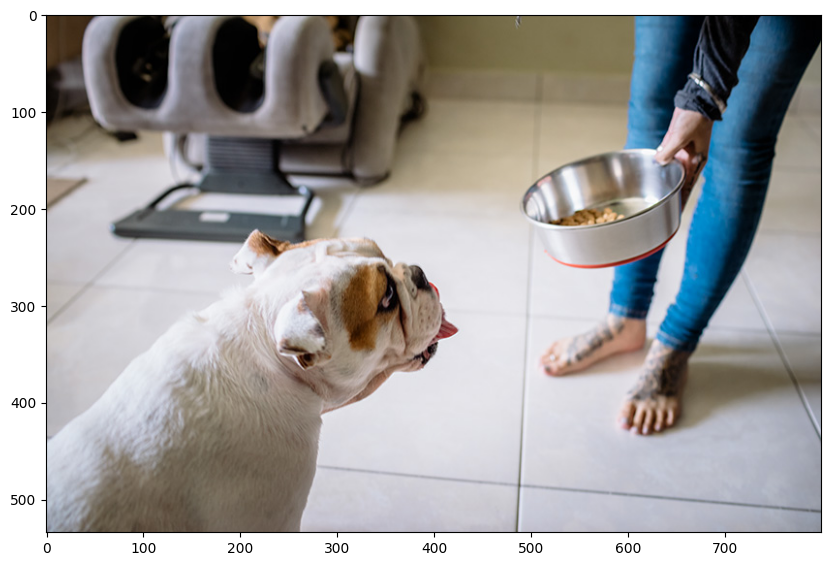

In [ ]:
# Display the original image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis ('on')
plt.show()

In [ ]:
# Define input point and label
input_point =  np.array([[200, 400]])
input_label = np.array([1])

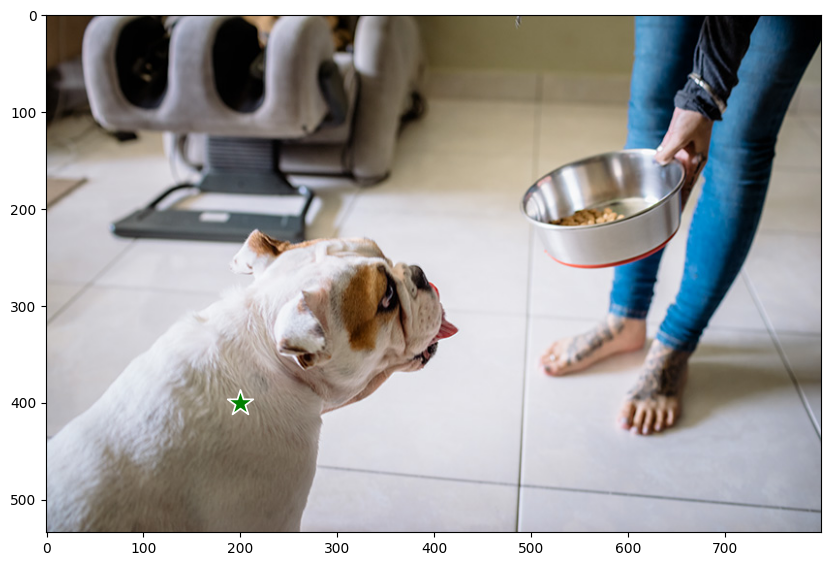

In [ ]:
# Display the image with the input point
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points (input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
# Perform prediction using SAM

mask, score, logit = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [ ]:
# Converts mask to a PIL image.
mask = Image.fromarray(mask[0,:,:])

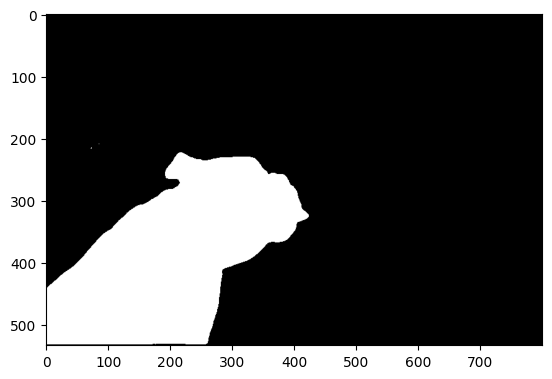

In [ ]:
plt.imshow(mask)

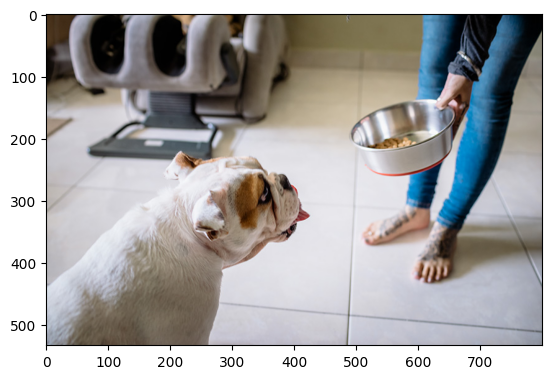

In [ ]:
plt.imshow(image)
# Convert the PIL Image to a NumPy array
image_np = np.array(image)
# Convert BGR to RGB format
rgb_image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
# Create a PIL image object
image = Image.fromarray(rgb_image)
# Show the PIL image object
image.show()

In [ ]:
# Resize the image and mask
image = image.resize((512,512))
mask = mask.resize((512,512))

In [ ]:
!nvidia-smi

Fri Dec 20 17:24:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              28W /  70W |   6385MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install required libraries for Stable Diffusion
!pip install diffusers
!pip install transformers scipy ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install huggingface_hub==0.25.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.27.0
    Uninstalling huggingface-hub-0.27.0:
      Successfully uninstalled huggingface-hub-0.27.0


In [ ]:
#!pip install diffusers transformers accelerate scipy safetensors

In [ ]:
#!pip uninstall diffusers
#!pip install diffusers

In [ ]:
# Load the Stable Diffusion inpainting pipeline
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda") # Moves the pipeline
pipe.enable_attention_slicing() #for less VRAM usage

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

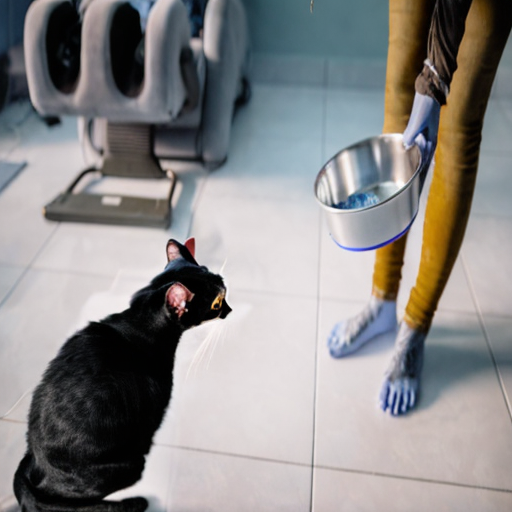

In [ ]:
#give the replacement prompt
prompt = "Replace dog with cat"
result = pipe (prompt, image= image, mask_image = mask, num_inference_steps = 50, guidance_scale = 11).images
result[0]


## **Conclusion**
#### This project successfully demonstrated image inpainting using a combination of the Segment Anything Model (SAM) and Stable Diffusion.  SAM accurately identified the region of interest defined by a user-specified point, generating a precise mask. This mask was then used by Stable Diffusion to seamlessly integrate a new image element based on a text prompt, effectively replacing the masked area.  The pipeline, leveraging GPU acceleration, produced high-quality inpainted images efficiently. Due to resource limitations, the Stable Diffusion 3.5 model could not be utilized in this demonstration. Future work could explore improvements in mask generation through incorporating multiple input points or bounding boxes, experimenting with different Stable Diffusion models, and refining the text prompting system for more nuanced control over the inpainted region.
